# API Development

This is already in active development:
https://github.com/lukas-weber/Carlo.jl

In [30]:
using Random 
#########################
# Core Abstractions
#########################
abstract type AbstractSystem end
abstract type AbstractLogWeight end
abstract type AbstractAlgorithm end
abstract type AbstractUpdate end
abstract type AbstractMeasurement end

## Core concept

### System
- contains state and constraints
- Bayesian case: data and latent variables
- needed to calculate log_weight

### LogWeight
- Callable (object or function) that operates on system
- stores e.g. temperature for Boltzmann
- includes a measure (for muca dx, for continuous functions this is None?)
- Baysian case: log_likelihood + log_prior

### Sampling/Algorithm
- object that holds logweight that is a function on the system
- TODO: Should this also have a pointer to the system and store the current logweight?
- this is essentially "the" markov chain

### Update
- function(System, Algorihtm)
- needs to coordinate how system and logweight interact
- For pre-implemented versions this should be as general as possible

## Measurements

This is in my opinion super nice! Works very well also.

In [31]:
using StatsBase
struct Measurement{F,T}
    observable::F
    data::T  # Vector, Histogram, etc.
end
Measurement(pair::Pair{<:Function}) = Measurement(pair.first, pair.second)
# single measurement
function measure!(measurement::Measurement, sys; kwargs...)
    value = measurement.observable(sys)
    push!(measurement.data, value)
end

# define different measurement schedules
abstract type MeasurementSchedule end
mutable struct IntervalSchedule <: MeasurementSchedule
    interval::Float64
    _checkpoint::Float64
    IntervalSchedule(interval) = new(interval, 0.0)
end
mutable struct PreallocatedSchedule <: MeasurementSchedule
    times::Vector{Float64}
    checkpoint_idx::Int
    PreallocatedSchedule(times) = new(sort(times), 1)
end

# Main measurements container
mutable struct Measurements{K,S<:MeasurementSchedule}
    measurements::Dict{K, Measurement}
    schedule::S
end
function Measurements(measurements::Dict{K, Measurement}; interval::Real) where K
    schedule = IntervalSchedule(interval)
    Measurements{K, typeof(schedule)}(measurements, schedule)
end
function Measurements(measurements::Dict{K, Measurement}, times::Vector{<:Real}) where K
    schedule = PreallocatedSchedule(Float64.(times))
    Measurements{K, typeof(schedule)}(measurements, schedule)
end
function Measurements(pairs::Vector{<:Pair{K}}; interval::Real) where K <: Union{Symbol, String}
    measurements = Dict{K, Measurement}(name => Measurement(pair) for (name, pair) in pairs)
    Measurements(measurements, interval=interval)
end
function Measurements(pairs::Vector{<:Pair{K}}, times::Vector{<:Real}) where K <: Union{Symbol, String}
    measurements = Dict{K, Measurement}(name => Measurement(pair) for (name, pair) in pairs)
    Measurements(measurements, times)
end

Base.getindex(m::Measurements{K}, key::K) where K = m.measurements[key]
Base.setindex!(m::Measurements{K}, val, key::K) where K = m.measurements[key] = val

# Interval-based measurement (indefinite)
function measure!(measurements::Measurements{K, IntervalSchedule}, sys, t; kwargs...) where K
    schedule = measurements.schedule
    if t >= schedule._checkpoint
        for (name, measurement) in measurements.measurements
            measure!(measurement, sys; kwargs...)
        end
        schedule._checkpoint += schedule.interval
    end
end

# Preallocated time-based measurement (handles event skipping)
function measure!(measurements::Measurements{K, PreallocatedSchedule}, sys, t; kwargs...) where K
    schedule = measurements.schedule
    # Process all checkpoints that have been passed
    while schedule.checkpoint_idx <= length(schedule.times) &&
        t >= schedule.times[schedule.checkpoint_idx]
            
        for (name, measurement) in measurements.measurements
            measure!(measurement, sys; kwargs...)
        end
        
        schedule.checkpoint_idx += 1
    end
end

# Helper to check if measurements are complete
is_complete(m::Measurements{K, IntervalSchedule}) where K = false  # indefinite
is_complete(m::Measurements{K, PreallocatedSchedule}) where K = 
    m.schedule.checkpoint_idx > length(m.schedule.times)

is_complete (generic function with 2 methods)

## Equilibriium

In [32]:
# abstract type ImportanceSampling <: AbstractAlgorithm end
# create basic fields for importance sampling algorithms
abstract type AbstractImportanceSampling <: AbstractAlgorithm end
function delta_log_weight(alg::AbstractImportanceSampling, sys::AbstractSystem, dx)
    error("log_weight not implemented for $(typeof(alg)) and $(typeof(sys))")
end

# new abstraction
@inline function accept!(alg::AbstractImportanceSampling, log_ratio::Real)
    alg.steps += 1
    accepted = log_ratio > 0 || rand(alg.rng) < exp(log_ratio)
    alg.accepted += accepted 
    return accepted
end

accept! (generic function with 1 method)

### Example: Distribution sampling 

BenchmarkTools.Trial: 10000 samples with 776 evaluations per sample.
 Range (min … max):  229.166 ns …   6.441 μs  ┊ GC (min … max): 0.00% … 95.41%
 Time  (median):     246.671 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   255.240 ns ± 103.304 ns  ┊ GC (mean ± σ):  2.53% ±  6.62%

      ▄██▅▃▃▂                                                    
  ▂▂▄▇███████▇▆▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▁▁▁▂▁▂▂▁▂▁▂▁▁▁▂ ▃
  229 ns           Histogram: frequency by time          373 ns <

 Memory estimate: 153 bytes, allocs estimate: 9.

Benchmarking with stored current weight:
Benchmarking with recalculated current weight:
Recalculation is faster because the log_weight is so cheap to compute
Acceptance rate: 0.713858807113032
mean: -0.0022328328864936946 error:0.003170595761607974
std: 1.002635427775285


BenchmarkTools.Trial: 10000 samples with 807 evaluations per sample.
 Range (min … max):  187.113 ns …   7.885 μs  ┊ GC (min … max): 0.00% … 97.04%
 Time  (median):     192.947 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   200.373 ns ± 117.519 ns  ┊ GC (mean ± σ):  2.49% ±  5.38%

      ▅█▇▅▂                                                      
  ▁▁▃▇█████▇▆▅▄▅▄▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  187 ns           Histogram: frequency by time          232 ns <

 Memory estimate: 148 bytes, allocs estimate: 9.

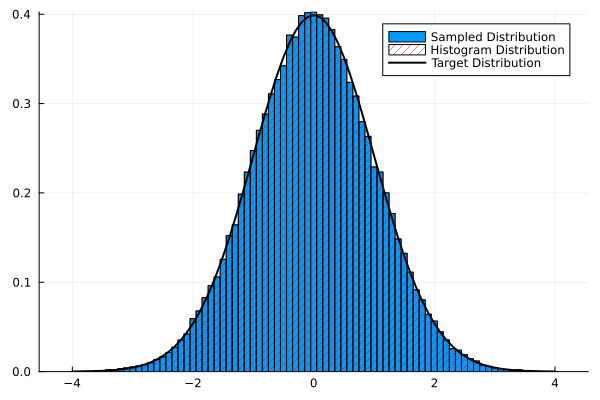

In [33]:
######## Setup ##########
mutable struct State <: AbstractSystem
    x :: Real
end
state = State(0.0)

# alternatively this is called model, e.g. in Turing.jl
@inline logdensity(x::Real) = - x^2 / 2.0
@inline logdensity(state::State) = logdensity(state.x)

mutable struct ImportanceSampling_cached <: AbstractImportanceSampling
    rng :: AbstractRNG
    logweight :: Base.Callable
    current_logweight :: Real # <- currently a test for optimization, could be interesting in general
    steps :: Int
    accepted :: Int
    # ImportanceSampling(rng::AbstractRNG, logweight::Base.Callable) = new(rng, logweight, 0, 0)
    ImportanceSampling_cached(rng::AbstractRNG, logweight::Base.Callable, state) = new(rng, logweight, logweight(state) , 0, 0)
end

mutable struct ImportanceSampling <: AbstractImportanceSampling
    rng :: AbstractRNG
    logweight :: Base.Callable
    steps :: Int
    accepted :: Int
    ImportanceSampling(rng::AbstractRNG, logweight::Base.Callable) = new(rng, logweight, 0, 0)
end

alg_cached = ImportanceSampling_cached(MersenneTwister(42), logdensity, state)
alg = ImportanceSampling(MersenneTwister(42), logdensity)

# this is not "the" but one update (like a spin flip)
@inline function uniform_shift!(state, alg::ImportanceSampling_cached, range::Real)
    dx = ( 2*rand(alg.rng) - 1 ) * range       
    new_logweight = alg.logweight(state.x + dx)
    log_ratio = new_logweight - alg.current_logweight
    if accept!(alg, log_ratio)
        state.x += dx
        alg.current_logweight = new_logweight
    end
    return nothing
end
@inline function uniform_shift!(state, alg::ImportanceSampling, range::Real)
    dx = ( 2*rand(alg.rng) - 1 ) * range
    log_ratio = alg.logweight(state.x + dx) - alg.logweight(state.x)       
    if accept!(alg, log_ratio)
        state.x += dx
    end
    return nothing
end

######## Sampling ##########
# run once to avoid compilation overhead
uniform_shift!(state, alg_cached, 1.5)
uniform_shift!(state, alg, 1.5)

# benchmarking measurement overhead
using BenchmarkTools
print("Benchmarking with stored current weight:\n")
display(@benchmark uniform_shift!(state, alg_cached, 1.5))

print("Benchmarking with recalculated current weight:\n")
display(@benchmark uniform_shift!(state, alg, 1.5))

println("Recalculation is faster because the log_weight is so cheap to compute")

bins = collect(-4.05:0.1:4.05)
measurements = Measurements([
    :timeseries => (sys->sys.x) => Float64[],
    :histogram => (sys->sys.x) => fit(Histogram, Float64[], bins)
], interval=10)

for i in 1:1e3
    uniform_shift!(state, alg, 1.5)
end
for i in 1:1e6
    uniform_shift!(state, alg, 1.5)
    measure!(measurements, state, i)
end

######## Analysis ##########
print("Acceptance rate: ", alg.accepted / alg.steps, "\n")
mean_x = mean(measurements[:timeseries].data)
std_x = std(measurements[:timeseries].data, mean=mean_x)
# error of mean_x: from fluctuations
err_mean_x = std_x / sqrt(length(measurements[:timeseries].data))
print("mean: ", mean_x, " error:", err_mean_x, "\n")
print("std: ", std_x, "\n")
#plot distribution
using Plots
using Distributions
histogram(measurements[:timeseries].data, bins=bins, normalize=true, label="Sampled Distribution")
meas_dist = StatsBase.normalize(measurements[:histogram].data, mode=:pdf)
plot!(meas_dist, label="Histogram Distribution", alpha=0.5, fillalpha=0.5, fillcolor=:red, fillstyle=:/)
x = -4:0.1:4
plot!(x, pdf.(Normal(0,1), x), label="Target Distribution", color=:black, lw=2)

# ref (store current weight):  207.942 ns (9 allocations: 153 bytes)
# ref (recalc current weight):  178.182 ns (9 allocations: 148 bytes)

### Example: Baysian inference of mean of iid Gaussian measurements

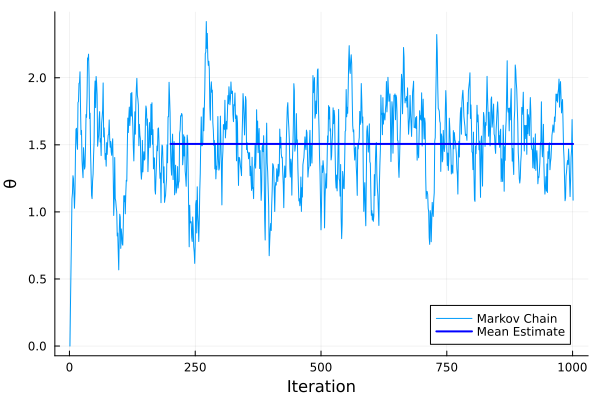

In [55]:
using Random

mutable struct BayesSystem <: AbstractSystem
    θ :: Float64       # latent mean
    y :: Vector{Float64}  # observed data
end

# defined twice in this notebook for clarity
struct BoltzmannLogWeight <: AbstractLogWeight
    β :: Real
end
mutable struct Metropolis <: AbstractImportanceSampling
    rng :: AbstractRNG
    logweight :: AbstractLogWeight
    steps :: Int
    accepted :: Int
    Metropolis(rng::AbstractRNG, logweight::AbstractLogWeight) = new(rng, logweight, 0, 0)
end
# special case (see later)
Metropolis(rng::AbstractRNG; β) = Metropolis(rng, BoltzmannLogWeight(β))

# here comes generalization to Bayes
@inline function (lw::BoltzmannLogWeight)(sys::BayesSystem)
    log_prior = -0.5 * sys.θ^2                       # standard normal prior
    log_likelihood   = -sum((sys.y .- sys.θ).^2)/2   # Gaussian likelihood
    return log_prior + lw.β * log_likelihood         # only likelihood scaled
end

function update!(sys::BayesSystem, alg::Metropolis, range::Float64)
    old_log_weight = alg.logweight(sys)
    old_θ = sys.θ
    # new proposal
    sys.θ = sys.θ .+ (2rand(rng)-1)*range
    new_log_weight = alg.logweight(sys)
    if log(rand(rng)) < new_log_weight - old_log_weight # accept
        # nothing
    else # reject    
        sys.θ = old_θ
    end
end

bins = collect(-4.05:0.1:4.05)
timeseries = Measurements([
    :theta => (sys->sys.θ) => Float64[],
], interval=10)
hist = Measurements([
    :theta => (sys->sys.θ) => fit(Histogram, Float64[], bins)
], interval=10)

# --- Example run ---
rng = MersenneTwister(42)
μ = 1.5
data = μ .+ randn(rng, 10)
sys = BayesSystem(0.0, data)
alg = Metropolis(rng; β=1.0)

# burn in 
for i in 1:1e3
    update!(sys, alg, 0.1)
    # measure only timeseries during burn-in
    measure!(timeseries, sys, i)
end

for i in 1e3:1e4 # needs to keep i incremental for the measurement with interval ... TODO
    update!(sys, alg, 0.1)
    measure!(timeseries, sys, i)
    measure!(hist, sys, i)
end

# plot evolution of timeseries (Markov Chain) and final histogram (posterior distribution with prior included)
using Plots
using Distributions
plot(timeseries[:theta].data, label="Markov Chain", xlabel="Iteration", ylabel="θ")
interval_estimate = Int(8e2)
mean_estimate = mean(timeseries[:theta].data[end-interval_estimate:end])
# plot the mean estimate on top of timeseries in the range where it is estimated
plot!([length(timeseries[:theta].data)-interval_estimate, length(timeseries[:theta].data)], [mean_estimate, mean_estimate], label="Mean Estimate", color=:blue, lw=2)

True mean: 1.5
Simple mean from data: 1.6906640568440945
Mean estimate from end of timeseries: 1.5066127109224878


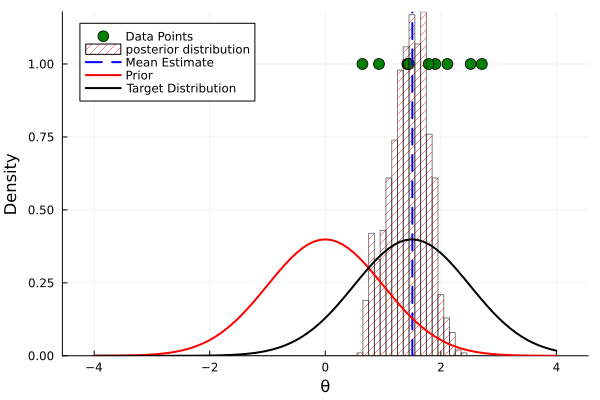

In [57]:
# plot histogram from data points in sys.y
# plot(histogram(sys.y, bins=bins), label="Data Points", xlabel="θ", ylabel="Density")
# plot only data points as markers
scatter(sys.y, ones(length(sys.y)), label="Data Points", xlabel="θ", ylabel="Density", markershape=:circle, markersize=6, color=:green)
# plot histogram with prior distribution
meas_dist = StatsBase.normalize(hist[:theta].data, mode=:pdf)
plot!(meas_dist, label="posterior distribution", alpha=0.5, fillalpha=0.5, fillcolor=:red, fillstyle=:/)
# plot veritcal line for the mean estimate from the mean distribution
print("True mean: ", μ, "\n")
print("Simple mean from data: ", mean(data), "\n")
print("Mean estimate from end of timeseries: ", mean_estimate, "\n")
plot!([mean_estimate, mean_estimate], [0, maximum(meas_dist.weights)], label="Mean Estimate", color=:blue, lw=2, ls=:dash)
x = -4:0.1:4
plot!(x, pdf.(Normal(0,1), x), label="Prior", color=:red, lw=2)
plot!(x, pdf.(Normal(μ,1), x), label="Target Distribution", color=:black, lw=2)

Notice that the prior here acts as a bias, which, because we know it, we could in principle reweight out again. However, in Bayesian inference, this prior has a meaning in the form of knowledge put in.

### Example: Ising

In [3]:
abstract type AbstractSpinSystem <: AbstractSystem end
@inline pick_site(rng, N) = rand(rng, UInt) % N + 1

########################
# general spin flip that would come with SpinSystems (currently in use for BC)
########################
function SpinFlip(sys::AbstractSpinSystem, alg::AbstractImportanceSampling)
    # pick a random spin (from the possible sites -> )
    i = pick_site(alg.rng, length(sys.spins))
    # system knows the possible spin states at site i
    s_new = rand(alg.rng, sys.states)
    # get current state of the system and the change from the update
    H = hamiltonian(sys)
    ΔH = delta_hamiltonian(sys, i, s_new)

    # H and dH can be vectors! E.g. to include the field etc.
    log_ratio = alg.logweight(H + ΔH) - alg.logweight(H)
    if accept!(alg, log_ratio)
        modify!(sys, i, s_new, ΔH) #<- modify the system to implement update 
    # in other update schemes this may include a rejection step ...
    end 
end
@inline function _local_spin_pairs(sys::AbstractSpinSystem, i)
    s = sys.spins[i]
    acc = 0
    for j in sys.nbrs[i]
        acc += s * sys.spins[j]
    end
    return acc
end

UndefVarError: UndefVarError: `AbstractSystem` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [4]:
log_dos_beale_8x8 = [ (-128, 0.6931471805599453), (-124, 0.0), (-120, 4.852030263919617), (-116, 5.545177444479562), (-112, 8.449342524508063), (-108, 9.793672686528922), (-104, 11.887298863200714), (-100, 13.477180596840947), (-96, 15.268195474147658), (-92, 16.912371686315282), (-88, 18.59085846191256), (-84, 20.230089202801466), (-80, 21.870810400320693), (-76, 23.498562234123614), (-72, 25.114602234581373), (-68, 26.70699035290573), (-64, 28.266152815389898), (-60, 29.780704423363996), (-56, 31.241053997806176), (-52, 32.63856452513369), (-48, 33.96613536105969), (-44, 35.217576663643314), (-40, 36.3873411250109), (-36, 37.47007844691906), (-32, 38.46041522581422), (-28, 39.35282710786369), (-24, 40.141667825183845), (-20, 40.82130289691285), (-16, 41.38631975325592), (-12, 41.831753810069756), (-8, 42.153328313883975), (-4, 42.34770636939425), (0, 42.41274640460084), (4, 42.34770636939425), (8, 42.153328313883975), (12, 41.831753810069756), (16, 41.38631975325592), (20, 40.82130289691285), (24, 40.141667825183845), (28, 39.35282710786369), (32, 38.46041522581422), (36, 37.47007844691906), (40, 36.3873411250109), (44, 35.217576663643314), (48, 33.96613536105969), (52, 32.63856452513369), (56, 31.241053997806176), (60, 29.780704423363996), (64, 28.266152815389898), (68, 26.70699035290573), (72, 25.114602234581373), (76, 23.498562234123614), (80, 21.870810400320693), (84, 20.230089202801466), (88, 18.59085846191256), (92, 16.912371686315282), (96, 15.268195474147658), (100, 13.477180596840947), (104, 11.887298863200714), (108, 9.793672686528922), (112, 8.449342524508063), (116, 5.545177444479562), (120, 4.852030263919617), (124, 0.0), (128, 0.6931471805599453) ];
struct BoltzmannDistribution <: ContinuousUnivariateDistribution
    pdf::Dict{Any,Float64}
    function log_sum(a::Number, b::Number)::Float64
        if b < a
            return a + log(1 + exp(b - a))
        else
            return b + log(1 + exp(a - b))
        end
    end
    function initialize_BoltzmannDistribution(beta, log_dos)
        # partition sum
        log_Z = -Inf
        for (E, log_d) in log_dos
            log_Z = log_sum(log_Z, log_d - beta * E)
        end

        pdf = Dict{Int64,Float64}()
        for (E, log_d) in log_dos
            log_pdf = log_d - beta * E - log_Z
            pdf[E] = exp(log_pdf)
        end
        return pdf
    end
    BoltzmannDistribution(beta, log_dos) = new(initialize_BoltzmannDistribution(beta, log_dos))
end

UndefVarError: UndefVarError: `ContinuousUnivariateDistribution` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [5]:
##########################
# Ising
##########################
using Graphs
# This is generalizable to H = - \sum J_{ij}s_i s_j + mu \sum_i h_i s_i
# depending on the type of J
mutable struct Ising{T} <: AbstractSpinSystem   
    spins :: Vector{Int8}            # ±1
    graph :: SimpleGraph
    nbrs  :: Vector{Vector{Int}}    # precomputed neighbors
    J     :: T
    sum_pairs :: Int                # sum of s_i s_j over edges
    sum_spins :: Int                # sum of spins

    function Ising(graph::SimpleGraph, J)
        T = typeof(J)
        if typeof(J) <: Vector{<:Real}
            # assert that length(J) == ne(graph)
            assert(length(J) == ne(graph))
        end

        nbrs = [collect(Graphs.neighbors(graph, i)) for i in 1:nv(graph)]

        # all spins = +1 ⇒ each pair contributes +1
        spins = ones(Int8, nv(graph))
        sum_pairs = ne(graph)
        sum_spins = nv(graph)

        new{T}(spins, graph, nbrs, J, sum_pairs, sum_spins)
    end
end
# Convenience lattice constructor
function Ising(dims::Vector{Int}; J=1, periodic=true)
    graph = Graphs.SimpleGraphs.grid(dims; periodic)
    return Ising(graph, J)
end

function init(sys::Ising, type::Symbol, rng=nothing, states=[-1, 1])
    if type == :up
        sys.spins .= 1
        sys.sum_pairs = ne(sys.graph)
        sys.sum_spins = length(sys.spins)
    elseif type == :down
        sys.spins .= -1
        sys.sum_pairs = ne(sys.graph)
        sys.sum_spins = -length(sys.spins)
    elseif type == :random
        @assert rng !== nothing
        for i in eachindex(sys.spins)
            sys.spins[i] = rand(rng, states)
        end
        # recompute bookkeeping
        sum_pairs = zero(sys.J)
        for i in 1:length(sys.spins)
            sum_pairs += _local_spin_pairs(sys, i)
        end
        sys.sum_pairs = sum_pairs/2
        sys.sum_spins = sum(sys.spins)
    end
    return sys
end

# ------------------------------------------------------------
# Observables
# ------------------------------------------------------------

@inline magnetization(sys::Ising) = abs(sys.sum_spins)
@inline energy(sys::Ising) = -sys.J * sys.sum_pairs

@inline delta_energy(sys::Ising, i) =
    2 * sys.J * _local_spin_pairs(sys, i)

# for spin updates
@inline function modify!(sys::Ising, i, ΔE)
    old = sys.spins[i]
    new = -old
    sys.spins[i] = new

    # bookkeeping 
    sys.sum_pairs -= ΔE / sys.J 
    sys.sum_spins += 2 * new

    return nothing
end


function SpinFlip(sys::Ising, alg::AbstractImportanceSampling)
    i = rand(1:length(sys.spins))
    ΔE = delta_energy(sys, i)   # here, we know that the log_ratio only needs the change in energy, so we can exploit that
    log_ratio = alg.logweight(ΔE)
    if accept!(alg, log_ratio) 
        modify!(sys, i, ΔE)
    end
end

UndefVarError: UndefVarError: `AbstractSpinSystem` not defined in `Main`
Suggestion: add an appropriate import or assignment. This global was declared but not assigned.

In [6]:
###########################
# Specific Metropolis
###########################

abstract type AbstractLogWeight end
struct BoltzmannLogWeight <: AbstractLogWeight
    β :: Real
end
@inline (lw::BoltzmannLogWeight)(E) = -lw.β * sum(E)

mutable struct Metropolis <: AbstractImportanceSampling
    rng :: AbstractRNG
    logweight :: BoltzmannLogWeight
    steps :: Int
    accepted :: Int
    Metropolis(rng::AbstractRNG; β) = new(rng, BoltzmannLogWeight(β), 0, 0)
end

# not sure why this is faster than the version with BoltzmannLogWeight
mutable struct Metropolis_old <: AbstractImportanceSampling
    rng :: AbstractRNG
    logweight :: Base.Callable
    β :: Real
    steps :: Int
    accepted :: Int
    Metropolis_old(rng::AbstractRNG; β) = new(rng, x -> -β * sum(x), β, 0, 0)
end

UndefVarError: UndefVarError: `AbstractImportanceSampling` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [7]:
using Random 
rng = MersenneTwister(42)
sys = Ising([8,8])
init(sys, :random, rng)
alg = Metropolis(rng, β=0.3)

measurements = Measurements([
    :energy => energy => Float64[],
    :magnetization => magnetization => Float64[]
], interval=10)

# thermalization
N = nv(sys.graph)
println("Total spins: ", N)

# benchmark the spinflip here
using BenchmarkTools
@btime SpinFlip(sys, alg)

for i in 1:N*1e3
    SpinFlip(sys, alg)
end

# measurement
for i in 1:N*1e4
    SpinFlip(sys, alg)
    measure!(measurements, sys, i)
end

# print results
println("Acceptance rate: ", alg.accepted / alg.steps)
println("Average energy: ", mean(measurements[:energy].data)/N)
println("Average magnetization: ", mean(measurements[:magnetization].data)/N)

UndefVarError: UndefVarError: `Ising` not defined in `Main`
Suggestion: add an appropriate import or assignment. This global was declared but not assigned.

In [8]:
# plot timeseries
using Plots
energies = measurements[:energy].data
plot(energies, label="Energy Timeseries", xlabel="Monte Carlo Steps", ylabel="Energy")

UndefVarError: UndefVarError: `measurements` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [9]:
# plot distribution of energy compared to exact
using Plots
energies = measurements[:energy].data
hist = fit(Histogram, energies, minimum(energies)-2:4:maximum(energies)+2, closed=:left)
dist = StatsBase.normalize(hist, mode=:probability)
plot(dist, label="Energy Distribution", xlabel="Energy", ylabel="Probability Density",
    title="Energy Distribution of 2D Ising Model at β=$(alg.logweight.β)")
# exact histogram
P_true = BoltzmannDistribution(alg.logweight.β, log_dos_beale_8x8).pdf
E_vals = sort(collect(keys(P_true)))
P_vals = [P_true[E] for E in E_vals]
plot!(E_vals, P_vals, label="Exact Distribution", color=:black, lw=2)

UndefVarError: UndefVarError: `measurements` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## Example: Sweep

In [10]:
# BlumeCapel (could most definitely be optimized further)
mutable struct BlumeCapel <: AbstractSpinSystem   
    spins :: Vector{Int8}            # -1, 0, +1
    graph :: SimpleGraph
    nbrs  :: Vector{Vector{Int}}    # precomputed neighbors
    states :: Vector{Int8}          # possible spin states
    J     :: Real
    D     :: Real
    sum_pairs :: Int                # sum of s_i s_j over edges
    sum_spins :: Int                # sum of spins
    sum_spins2 :: Int               # sum of s_i^2

    function BlumeCapel(graph::SimpleGraph, J, D)
        nbrs = [collect(Graphs.neighbors(graph, i)) for i in 1:nv(graph)]
        states = Int8[-1, 0, 1]

        # all spins = +1 ⇒ each pair contributes +1
        spins = ones(Int8, nv(graph))
        sum_pairs = ne(graph)
        sum_spins = nv(graph)
        sum_spins2 = nv(graph)

        new(spins, graph, nbrs, states,J, D, sum_pairs, sum_spins, sum_spins2)
    end
end
# Convenience lattice constructor
function BlumeCapel(dims::Vector{Int}; J=1, D=0, periodic=true)
    graph = Graphs.SimpleGraphs.grid(dims; periodic)
    return BlumeCapel(graph, J, D)
end
function init(sys::BlumeCapel, type::Symbol, rng=nothing) 
    if type == :up
        sys.spins .= 1
        sys.sum_pairs = ne(sys.graph)
        sys.sum_spins = length(sys.spins)
        sys.sum_spins2 = length(sys.spins)
    elseif type == :down
        sys.spins .= -1
        sys.sum_pairs = ne(sys.graph)
        sys.sum_spins = -length(sys.spins)
        sys.sum_spins2 = length(sys.spins)
    elseif type == :zero
        sys.spins .= 0
        sys.sum_pairs = 0
        sys.sum_spins = 0
        sys.sum_spins2 = 0
    elseif type == :random
        @assert rng !== nothing
        for i in eachindex(sys.spins)
            sys.spins[i] = rand(rng, sys.states)
        end
        # recompute bookkeeping
        sum_pairs = zero(sys.J)
        sum_spins = 0
        sum_spins2 = 0
        for i in 1:length(sys.spins)
            sum_pairs += _local_spin_pairs(sys, i)
            sum_spins += sys.spins[i]
            sum_spins2 += sys.spins[i]^2
        end
        sys.sum_pairs = sum_pairs/2
        sys.sum_spins = sum_spins
        sys.sum_spins2 = sum_spins2
    end
    return sys
end

@inline hamiltonian(sys::BlumeCapel) = [-sys.J * sys.sum_pairs, sys.D * sys.sum_spins2]
@inline magnetization(sys::BlumeCapel) = abs(sys.sum_spins)
@inline delta_hamiltonian(sys::BlumeCapel, i, s_new) = 
    [2 * sys.J * _local_spin_pairs(sys, i), sys.D * (s_new^2 - sys.spins[i]^2)]
@inline function modify!(sys::BlumeCapel, i, s_new, ΔH)
    old = sys.spins[i]
    sys.spins[i] = s_new 
    # bookkeeping
    sys.sum_pairs -= ΔH[1] / sys.J 
    sys.sum_spins += s_new - old
    sys.sum_spins2 += s_new^2 - old^2
    # throw error if sum_spins2 < 0
    if sys.sum_spins2 < 0
        error("sum_spins2 became negative: ", sys.sum_spins2)
    end
    return nothing
end

UndefVarError: UndefVarError: `AbstractSpinSystem` not defined in `Main`
Suggestion: add an appropriate import or assignment. This global was declared but not assigned.

In [11]:
using Random 
rng = MersenneTwister(42)
sys = BlumeCapel([8,8])
init(sys, :random, rng)
alg = Metropolis(rng, β=0.3)

measurements = Measurements([
    :energy => (sys->sum(hamiltonian(sys))) => Float64[],
    :magnetization => magnetization => Float64[]
], interval=10)

# thermalization
N = nv(sys.graph)
println("Total spins: ", N)

# benchmark the spinflip here
using BenchmarkTools
@btime SpinFlip(sys, alg)

function sweep(sys, alg)
    #ClusterUpdate(alg.rng, sys, version="Wolff" # <- not implemented yet
    for n in 1:3*N
        SpinFlip(sys, alg)
    end
end

for i in 1:1e3
    sweep(sys, alg)
end

# measurement
for i in 1:1e4
    sweep(sys, alg)
    measure!(measurements, sys, i)
end

# print results
println("Acceptance rate: ", alg.accepted / alg.steps)
println("Average energy: ", mean(measurements[:energy].data)/N)
println("Average magnetization: ", mean(measurements[:magnetization].data)/N)

UndefVarError: UndefVarError: `BlumeCapel` not defined in `Main`
Suggestion: add an appropriate import or assignment. This global was declared but not assigned.

## Example: Muca
Nice features:
- provide domain [x_min, x_max] and measure dx will deal with bins and access
- 

In [12]:
# multicanonical algorithm analogous to Metropolis (can be done custom as here, but later profits from advantage of helper functions, parallelization and stuff?)
abstract type GeneralizedEnsemble <: AbstractImportanceSampling end
# this is ideal place where the metric is defined that can be used for binning
struct MulticanonicalLogWeight <: AbstractLogWeight
    log_weight :: Vector{Float64}
    bins :: Vector{Float64}
    MulticanonicalLogWeight(bins) = new(zeros(Float64, length(bins)), bins)
end
@inline (lw::MulticanonicalLogWeight)(bin::Int) = lw.log_weight[bin]

mutable struct MyAlgorithm <: GeneralizedEnsemble
    rng :: AbstractRNG
    canonical_logweight :: BoltzmannLogWeight
    muca_logweight :: MulticanonicalLogWeight
    logweight :: Base.Callable
    steps :: Int
    accepted :: Int
    function MyAlgorithm(rng::AbstractRNG, bins; β::Real) 
        canonical_logweight = BoltzmannLogWeight(β)
        muca_logweight = MulticanonicalLogWeight(bins)
        # TODO: unclear why this is -muca_logweight instead of +muca_logweight ... somwhere i have a sign wrong
        log_weight = (H) -> canonical_logweight(H[1]) + muca_logweight(bin_from_energy(H[2]))
        return new(rng, canonical_logweight, muca_logweight, log_weight, 0, 0)
    end
end
bin_from_energy(E_D::Int)::Int = E_D + 1 # E_D is integer from 0 to N

# need to redefine what energy and energy_change mean here (remove J, D to add it later)
@inline hamiltonian(sys::BlumeCapel) = [sys.J * sys.sum_pairs, sys.sum_spins2]
@inline delta_hamiltonian(sys::BlumeCapel, i, s_new) = 
    [2 * sys.J * _local_spin_pairs(sys, i), s_new^2 - sys.spins[i]^2]

@inline function modify!(sys::BlumeCapel, i, s_new, ΔH)
    old = sys.spins[i]
    sys.spins[i] = s_new 
    # bookkeeping
    sys.sum_pairs -= ΔH[1] / sys.J
    sys.sum_spins2 += ΔH[2]
    # throw error if sum_spins2 < 0
    if sys.sum_spins2 < 0
        error("sum_spins2 became negative: ", sys.sum_spins2)
    end
    return nothing
end


UndefVarError: UndefVarError: `AbstractImportanceSampling` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [13]:
sys = BlumeCapel([8,8], J=1, D=0) 
rng = MersenneTwister(42)
init(sys, :random, rng)
N = nv(sys.graph)
alg = MyAlgorithm(rng, 0:N, β=0.3)

final_measurements = Measurements([
    :E_J => (sys->hamiltonian(sys)[1]) => Float64[],
    :E_D => (sys->hamiltonian(sys)[2]) => Float64[],
    :magnetization => magnetization => Float64[]
], interval=10)

# thermalization
for i in 1:1e3
    SpinFlip(sys, alg)
end

function muca_iteration(sys, alg, updates)
    histogram_E_D = Measurement(sys->hamiltonian(sys)[2], fit(Histogram, Int[], 0:100, closed=:left))
    for i in 1:updates
        SpinFlip(sys, alg)
        measure!(histogram_E_D, sys)
    end
    return histogram_E_D
end

histograms = []
log_weights = []
iterations = 10
using ProgressMeter
@showprogress for iter in 1:iterations
    hist_E_D = muca_iteration(sys, alg, 1e4*N)
    push!(histograms, hist_E_D)
    # update log_weights
    for bin in 1:length(alg.muca_logweight.log_weight)
        count = hist_E_D.data.weights[bin]
        if count > 0
            alg.muca_logweight.log_weight[bin] -= log(count)
        end
    end
    push!(log_weights, collect(alg.muca_logweight.log_weight))
end

UndefVarError: UndefVarError: `BlumeCapel` not defined in `Main`
Suggestion: add an appropriate import or assignment. This global was declared but not assigned.

In [14]:
# plot histograms
using Plots
# Create 2-panel plot
p1 = plot(yscale=:log, xlabel="E_D", ylabel="Counts", legend=:none, title="Counts (log scale)")
p2 = plot(xlabel="E_D", ylabel="log(Counts)", legend=:best, title="Log-transformed Counts")

for (i, hist) in enumerate(histograms)
    data = hist.data
    edges = data.edges[1]
    bin_centers = (edges[1:end-1] .+ edges[2:end]) ./ 2
    weights = data.weights
    
    # Only plot non-zero values
    mask = weights .> 0   
    if sum(mask) == 1
        # plot a scatter
        plot!(p1, bin_centers[mask], weights[mask], seriestype=:scatter,
              label="Iteration $i", markersize=4)
    else
        plot!(p1, bin_centers[mask], weights[mask], 
              label="Iteration $i", linewidth=2)
    end
end
for (i, log_weights) in enumerate(log_weights)
    plot!(p2, log_weights, 
          label="Iteration $i", linewidth=2)
end

# Combine into 2-panel figure and make sure I can actually see the x and y labels
plot(p1, p2, layout=(2,1), size=(800,500))

UndefVarError: UndefVarError: `histograms` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## Example: PT

In [15]:
# sys = Ising(L=10,J=1,d=2)
# rng = MersenneTwister(42)
# alg = ParallelTempering(rng, betas=[0.5, 1.0, 1.5, 2.0])
# # ReplicaExchange(rng, weights=[...])
# # ParallelTempering = ReplicaExchange 

# # the update function defines all the dynamics (links system and algorithm)
# function SpinFlip(sys::Ising, alg::ReplicaExchange)
#     # pick a random spin
#     i = rand(1:sys.N)
#     # this would need to be adapted for other algorithms e.g. PT in sub energy
#     dE = sys.dE(i)
#     # pass to importance sampling algorithm
#     if accept!(alg, sys, dE) # accept stores the acceptance rate etc in the algorithm
#         sys.spins[i] = -sys.spins[i] # flip spin
#     end
# end
# update!(sys) = SpinFlip(sys, alg, 0)

# # TODO: add replica exchange step every n steps and parallel structure!

# sim = Simulation(sys, update!)

# # thermalization
# run!(sim, 100)  
# # measurement
# run!(sim, 1e4, measure!)

## Example: Gillespie

In [16]:
# create a minimal Gillespiel example analoguous to the above Ising case
mutable struct BirthDeathProcess <: AbstractSystem
    N :: Real
    lambda :: Real
    mu :: Real
    rates :: Vector{Real} # population birth and death rates 
    BirthDeathProcess(N0::Int, lambda::Real, mu::Real) = new(N0, lambda, mu, [lambda*N0, mu*N0])
end

# define how the system changes upon a birth or a death event 
# TODO: event could be a symbol (:birth, :death) that is returned ... would this be performant?
function modify!(sys::BirthDeathProcess, event::Int)
    if event == 1 # :birth
        sys.N += 1
    elseif event == 2 # :death
        sys.N -= 1
    end
    # adapt rates 
    sys.rates[1] = sys.lambda * sys.N
    sys.rates[2] = sys.mu * sys.N
    return nothing
end

# Gillespie algorithm (should Gillespie have the rates? Can it inherit them from the system?). 
# analogous to a pointer onto the system!
mutable struct Gillespie <: AbstractAlgorithm
    rng :: AbstractRNG
    steps :: Int
    time :: Float64
    Gillespie(rng::AbstractRNG) = new(rng, 0, 0.0)
end

using MonteCarloX
# use MonteCarloX next! function (for now pass sys manually)
function next(alg::Gillespie, sys::BirthDeathProcess)
    sum_rates = sum(sys.rates)
    if !(sum_rates > 0)
        return Inf, 0
    end
    dtime = MonteCarloX.next_time(alg.rng, sum_rates)
    event = MonteCarloX.next_event(alg.rng, sys.rates)
    return dtime, event
end

UndefVarError: UndefVarError: `AbstractSystem` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [17]:
sys = BirthDeathProcess(10, 0.42, 0.4)
alg = Gillespie(MersenneTwister(23))

t=0.0
T=2e2

# this sets up a continuous measurement. Important to measure before modifying the system state!
measurements = Measurements([
    :timeseries => (sys->sys.N) => Float64[],
], collect(t:0.5:T))
measure!(measurements, sys, t)

# add a custom progressmeter
using ProgressMeter
while t <= T
    dt, id = next(alg, sys)
    t += dt
    # do measurement if t_meas < t 
    measure!(measurements, sys, t)
    # modify system state
    modify!(sys, id)
end
println("Final time: ", t, ", Final N: ", sys.N)

UndefVarError: UndefVarError: `BirthDeathProcess` not defined in `Main`
Suggestion: add an appropriate import or assignment. This global was declared but not assigned.

In [18]:
# plot the timeseries
using Plots
plot(measurements.schedule.times, measurements[:timeseries].data, label="Population Timeseries", xlabel="Time", ylabel="Population N")

UndefVarError: UndefVarError: `measurements` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

### Rare-event sampling in Ornstein Uhlenbeck Process

In [19]:
# the system is the trajectory
# dx_t = (- x_t / τ) dt  + σ dW_t
# <η(t)η(t')> = δ(t-t')
# simulate with Euler-Maruyama
include("../src/rng.jl")
"""
This function integrates an Ornstein-Uhlenbeck process using the Euler-Maruyama method starting from index `start` in the vector `x` using a mutable random number generator `rng`.
"""
mutable struct OUTrajectory <: AbstractSystem
    rng :: MutableRandomNumbers #<-- this is the state where we sample on
    τ :: Real
    σ :: Real
    T :: Real
    dt :: Real
    x0 :: Real
    x :: Vector{Real}
    _sum_x1 :: Real
    _sum_x2 :: Real
    _sum_x3 :: Real
    function OUTrajectory(;τ::Real, σ::Real = 1.0, T::Real, dt::Real, x0::Real = 0.0)
        num_steps = Int(floor(T/dt)) + 1
        # create rngs
        rng = MutableRandomNumbers(MersenneTwister(42), num_steps, mode=:static)
        x = zeros(Float64, num_steps)
        _sum_x1 = 0.0
        _sum_x2 = 0.0
        _sum_x3 = 0.0
        return new(rng, τ, σ, T, dt, x0, x, _sum_x1, _sum_x2, _sum_x3)
    end
end

# integration that can be only partial and keeps track of moments
function integrateOU!(state::OUTrajectory, start::Int = 1)
    rngs = state.rng.random_numbers
    for n in start:length(state.x) - 1
        old_state = state.x[n+1]
        state._sum_x1 -= old_state
        state._sum_x2 -= old_state^2
        state._sum_x3 -= old_state^3
        dW = sqrt(state.dt) * rngs[n]
        state.x[n+1] = state.x[n] - (state.x[n]/state.τ)*state.dt + state.σ * dW
        new_state = state.x[n+1]
        state._sum_x1 += new_state
        state._sum_x2 += new_state^2
        state._sum_x3 += new_state^3
    end
    return nothing
end

# energy function is some moment of the the temporal evolution, e.g. the third moment
@inline function energy(state::OUTrajectory)
    Ex1 = state._sum_x1 / length(state.x)
    Ex2 = state._sum_x2 / length(state.x)
    Ex3 = state._sum_x3 / length(state.x)
    return Ex3 - 3 * Ex1 * Ex2 + 2 * Ex1^3
end

UndefVarError: UndefVarError: `AbstractSystem` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [20]:
system = OUTrajectory(τ=1.0, σ=1.0, T=10.0, dt=0.1)
# initial integration 
# TODO: this is currently wrong because OU requires Gaussian random numbers. But no problem for the initial testing of API (just needs adaptation of RNG class)
integrateOU!(system)
println("Initial energy: ", energy(system))
using Plots
plot(system.x, label="OU Trajectory", xlabel="Time Steps", ylabel="x(t)")

UndefVarError: UndefVarError: `OUTrajectory` not defined in `Main`
Suggestion: add an appropriate import or assignment. This global was declared but not assigned.

In [21]:
# Monte Carlo on the random numbers driving the OU process
alg = Metropolis(MersenneTwister(42), β=0.3)
function RandomNumberShift!(system::OUTrajectory, alg::Metropolis, range::Real)
    # pick a random index in the random number array
    i = rand(alg.rng, 1:length(system.rng.random_numbers))
    # compute old energy
    old_energy = energy(system)
    # store old state
    backup_rng = system.rng
    backup_x = copy(system.x)
    backup_sum_x1 = system._sum_x1
    backup_sum_x2 = system._sum_x2
    backup_sum_x3 = system._sum_x3
    # TODO: propose a shift that respects the Gaussian nature of the random numbers?
    drn = (2 * rand(alg.rng) - 1) * range
    old_rn = system.rng.random_numbers[i]
    new_rn = old_rn + drn
    # temporarily modify the random number
    system.rng.random_numbers[i] = new_rn
    # re-integrate from index i
    integrateOU!(system, i)
    # compute new energy
    new_energy = energy(system)
    log_ratio = -alg.logweight(new_energy) + alg.logweight(old_energy)
    if accept!(alg, log_ratio)
        # accepted, keep changes
    else
        # rejected, revert changes
        system.rng = backup_rng
        system.x = backup_x
        system._sum_x1 = backup_sum_x1
        system._sum_x2 = backup_sum_x2
        system._sum_x3 = backup_sum_x3
    end
    return nothing
end

trajectories = []
energies = []
# run some MC steps
for i in 1:1e5
    # here range 1 is okay because random numbers should be ~ N(0,1)?
    # actually, we have to factorize the Gaussian distribution in here as well ... We could redraw from Gaussian instead of uniform shift?
    RandomNumberShift!(system, alg, 1)
    if i % 1000 == 0
        push!(trajectories, copy(system.x))
        push!(energies, energy(system))
    end
end 

# print acceptance rate
println("Acceptance rate: ", alg.accepted / alg.steps)

# plot trajectories on the left and distribution of energies on the right
using Plots
p1 = plot(title="OU Trajectories under MC Random Number Shifts", xlabel="Time Steps", ylabel="x(t)")
for (i, traj) in enumerate(trajectories)
    plot!(p1, traj, alpha=0.6, color=:gray, label="")
end
p2 = histogram(energies, bins=30, xlabel="Energy", ylabel="Counts", title="Energy Distribution", label="")
plot(p1, p2, layout=(1,2), size=(900,400))


UndefVarError: UndefVarError: `Metropolis` not defined in `Main`
Suggestion: add an appropriate import or assignment. This global was declared but not assigned.

### Rare-event sampling in random matrices

In [22]:
# Simplest first model: random directed ER graph with probability p to form an edge
include("../src/rng.jl")
using LinearAlgebra
# using Arpack
mutable struct RandomSample <: AbstractSystem
    rng :: MutableRandomNumbers
    connectivity :: Matrix{Float64}
    largest_eigenvalue :: Float64
    function RandomSample(num_nodes::Int, p::Real)
        num_edges = num_nodes * num_nodes
        rng = MutableRandomNumbers(MersenneTwister(42), num_edges, mode=:static)
        # each connectivity is zero or one with probability p, where we can use rng.random_numbers as a vector
        connectivity = reshape(rng.random_numbers, num_nodes, num_nodes) .< p
        print("Generated connectivity matrix with $(sum(connectivity)) edges.\n")
        largest_eigenvalue = maximum(abs, eigvals(connectivity))
        # λmax = eigs(connectivity; nev=1, which=:LM)[1][1]
        return new(rng, connectivity, largest_eigenvalue)
    end
end

UndefVarError: UndefVarError: `AbstractSystem` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [23]:
state = RandomSample(20, 0.3)
println("Largest eigenvalue: ", state.largest_eigenvalue)

UndefVarError: UndefVarError: `RandomSample` not defined in `Main`
Suggestion: add an appropriate import or assignment. This global was declared but not assigned.

In [24]:
# get distribution of largest eigenvalue first by simple sampling
num_samples = Int(1e4)
N = 20
p = 0.3
largest_eigenvalues = zeros(Float64, num_samples)
rng = MersenneTwister(42)
@showprogress for i in 1:num_samples
    # generate new connectivity
    connectivity = rand(rng, N, N) .< p
    largest_eigenvalues[i] = maximum(abs, eigvals(connectivity))
end

LoadError: LoadError: UndefVarError: `@showprogress` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
in expression starting at /Users/johannes/.julia/dev/MonteCarloX/examples/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X56sZmlsZQ==.jl:7

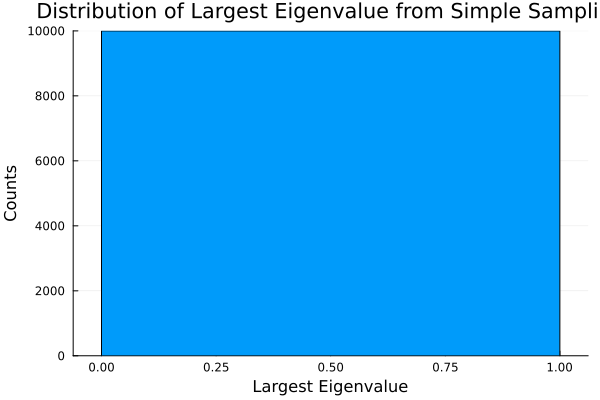

In [25]:
# plot
using Plots
histogram(largest_eigenvalues, bins=50, xlabel="Largest Eigenvalue", ylabel
="Counts", title="Distribution of Largest Eigenvalue from Simple Sampling", label="")

In [26]:
# now sample with Metropolis algorithm using beta=0 first
alg = Metropolis(MersenneTwister(42), β=0.0)
function ModifyEdge!(sys::RandomSample, alg::Metropolis)
    N = size(sys.connectivity, 1)
    # pick a random edge
    i = rand(alg.rng, 1:N)
    j = rand(alg.rng, 1:N)
    # compute old largest eigenvalue
    old_λmax = sys.largest_eigenvalue
    # update i,j edge
    old_value = sys.connectivity[i,j]
    # update random number in rng.random_numbers
    index = (i - 1) * N + j
    # draw new random number
    new_rn = rand(alg.rng)
    old_rn = sys.rng.random_numbers[index]
    sys.rng.random_numbers[index] = new_rn
    # update connectivity
    sys.connectivity[i,j] = new_rn < 0.3
    # compute new largest eigenvalue
    new_λmax = maximum(abs, eigvals(sys.connectivity))
    log_ratio = -alg.logweight(new_λmax) + alg.logweight(old_λmax)
    if accept!(alg, log_ratio)
        # accepted, keep changes
        sys.largest_eigenvalue = new_λmax
    else
        # rejected, revert changes
        sys.rng.random_numbers[index] = old_rn
        sys.connectivity[i,j] = old_value
    end
end
# run some MC steps
num_mc_steps = Int(1e5)
sampled_largest_eigenvalues = zeros(Float64, num_mc_steps)
@showprogress for i in 1:num_mc_steps
    ModifyEdge!(state, alg)
    sampled_largest_eigenvalues[i] = state.largest_eigenvalue
end

UndefVarError: UndefVarError: `Metropolis` not defined in `Main`
Suggestion: add an appropriate import or assignment. This global was declared but not assigned.

In [27]:
alg = Metropolis(MersenneTwister(42), β=3)
# run some MC steps
num_mc_steps = Int(1e5)
sampled_largest_eigenvalues_beta = zeros(Float64, num_mc_steps)
@showprogress for i in 1:num_mc_steps
    ModifyEdge!(state, alg)
    sampled_largest_eigenvalues_beta[i] = state.largest_eigenvalue
end

UndefVarError: UndefVarError: `Metropolis` not defined in `Main`
Suggestion: add an appropriate import or assignment. This global was declared but not assigned.

In [28]:
# plot together with simple sampling
using Plots
histogram(largest_eigenvalues, bins=50, xlabel="Largest Eigenvalue", ylabel="Counts", title="Distribution of Largest Eigenvalue: Simple Sampling vs Metropolis", label="Simple Sampling", alpha=0.5, normalize=true)
histogram!(sampled_largest_eigenvalues, bins=50, label="Metropolis Sampling", alpha=0.5, normalize=true)
histogram!(sampled_largest_eigenvalues_beta, bins=50, label="Metropolis Sampling (β=3)", alpha=0.5, normalize=true)

UndefVarError: UndefVarError: `sampled_largest_eigenvalues` not defined in `Main`
Suggestion: check for spelling errors or missing imports.